# Generating new images with Conditional GAN

In this example, we'll use TensorFlow 2.0 / Keras to implement Conditional GAN for generating new MNIST images.

_The code is based on_ [https://github.com/eriklindernoren/Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)<br />
_Author of the base implemenation: Erik Linder-Norén_ <br />
_License: MIT_

Let's start with the imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import \
    BatchNormalization, Input, Dense, Reshape, Flatten, Embedding, multiply

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

We'll continue with the definition of the generator, which takes as input the latent vector `z`, as well as the desired class of the generated image:

In [2]:
def build_generator(z_input: Input, label_input: Input):
    """
    Build generator CNN
    :param z_input: latent input
    :param label_input: conditional label input
    """

    model = Sequential([
        Dense(128, input_dim=latent_dim),
        LeakyReLU(alpha=0.2), BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2), BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2), BatchNormalization(momentum=0.8),
        Dense(np.prod((28, 28, 1)), activation='tanh'),
        # reshape to MNIST image size
        Reshape((28, 28, 1))
    ])

    model.summary()

    # the latent input vector z
    label_embedding = Embedding(input_dim=10, output_dim=latent_dim)(label_input)
    flat_embedding = Flatten()(label_embedding)

    # combine the noise and label by element-wise multiplication
    model_input = multiply([z_input, flat_embedding])
    image = model(model_input)

    return Model([z_input, label_input], image)

Next, we'll define the disciriminator, which takes either fake or real images as input, as well as the desired class of the input image:

In [3]:
def build_discriminator():
    """
    Build discriminator network
    """

    model = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid'),
    ], name='discriminator')

    model.summary()

    image = Input(shape=(28, 28, 1))
    flat_img = Flatten()(image)

    label_input = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(input_dim=10, output_dim=np.prod((28, 28, 1)))(label_input)
    flat_embedding = Flatten()(label_embedding)

    # combine the noise and label by element-wise multiplication
    model_input = multiply([flat_img, flat_embedding])

    validity = model(model_input)

    return Model([image, label_input], validity)

Let's continue with the training process. It alternates between training the discriminator with sets of real and fake images, and training the generator (using the combined discriminator/generator model):

In [4]:
def train(generator, discriminator, combined, steps, batch_size):
    """
    Train the GAN system
    :param generator: generator
    :param discriminator: discriminator
    :param combined: stacked generator and discriminator
    we'll use the combined network when we train the generator
    :param steps: number of alternating steps for training
    :param batch_size: size of the minibatch
    """

    # Load the dataset
    (x_train, x_labels), _ = mnist.load_data()

    # Rescale in [-1, 1] interval
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)

    # Discriminator ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for step in range(steps):
        # Train the discriminator
        # Select a random batch of images and labels
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images, labels = x_train[idx], x_labels[idx]

        # Random batch of noise
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        generated_images = generator.predict([noise, labels])

        # Train the discriminator
        discriminator_real_loss = discriminator.train_on_batch([real_images, labels], real)
        discriminator_fake_loss = discriminator.train_on_batch([generated_images, labels], fake)
        discriminator_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)

        # Train the generator
        # random latent vector z
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Condition on labels
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

        # Train the generator
        # Note that we use the "valid" labels for the generated images
        # That's because we try to maximize the discriminator loss
        generator_loss = combined.train_on_batch([noise, sampled_labels], real)

        # Display progress
        if step % 1000 == 0:
            print("%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generator loss: %.4f%%]" %
                  (step, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))


Next, we'll define the `plot_generated_images` function, which generates a grid of newly generated MNIST images, based on their desired class:

In [5]:
def plot_generated_images(generator, label: int):
    """
    Display a nxn 2D manifold of digits
    :param generator: the generator
    :param label: generate images of particular label
    """
    n = 10
    digit_size = 28

    # big array containing all images
    figure = np.zeros((digit_size * n, digit_size * n))

    # n*n random latent distributions
    noise = np.random.normal(0, 1, (n * n, latent_dim))
    sampled_labels = np.full(n * n, label, dtype=np.int64).reshape(-1, 1)

    # generate the images
    generated_images = generator.predict([noise, sampled_labels])

    # fill the big array with images
    for i in range(n):
        for j in range(n):
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))

    # plot the results
    plt.figure(num=label, figsize=(6, 5))
    plt.axis('off')
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    plt.close()

Finally, let's put it all together. We'll start by instantiating the `generator`, the `discrimantor`, the `combined` model, and the training framework. Then, we'll initiate the training for 50,000 episodes. To see the results of the training, we'll plot a grid of new images for each of the 10 MNIST classes:

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 233,985
Trainable params: 233,985
Non-trainable params: 0
_______________________________________________

W1209 12:51:13.721078 140482357958464 network.py:1299] Model inputs must come from `tf.keras.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "model_2" was not an Input tensor, it was generated by layer input_3.
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_3:0


0 [Discriminator loss: 0.6911%, acc.: 36.50%] [Generator loss: 0.6857%]
1000 [Discriminator loss: 0.7184%, acc.: 21.50%] [Generator loss: 0.7251%]
2000 [Discriminator loss: 0.6989%, acc.: 43.00%] [Generator loss: 0.7138%]
3000 [Discriminator loss: 0.6960%, acc.: 50.00%] [Generator loss: 0.7045%]
4000 [Discriminator loss: 0.6930%, acc.: 44.00%] [Generator loss: 0.7101%]
5000 [Discriminator loss: 0.6857%, acc.: 51.00%] [Generator loss: 0.7138%]
6000 [Discriminator loss: 0.6905%, acc.: 54.00%] [Generator loss: 0.7125%]
7000 [Discriminator loss: 0.6784%, acc.: 53.50%] [Generator loss: 0.7325%]
8000 [Discriminator loss: 0.6799%, acc.: 54.00%] [Generator loss: 0.7596%]
9000 [Discriminator loss: 0.6940%, acc.: 54.00%] [Generator loss: 0.7251%]
10000 [Discriminator loss: 0.6811%, acc.: 56.50%] [Generator loss: 0.7967%]
11000 [Discriminator loss: 0.6504%, acc.: 57.00%] [Generator loss: 0.7657%]
12000 [Discriminator loss: 0.6609%, acc.: 57.00%] [Generator loss: 0.8434%]
13000 [Discriminator loss

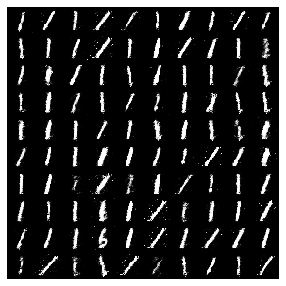

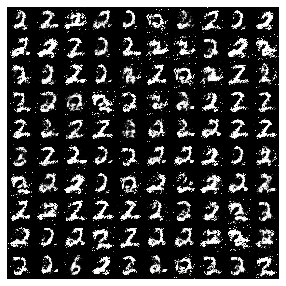

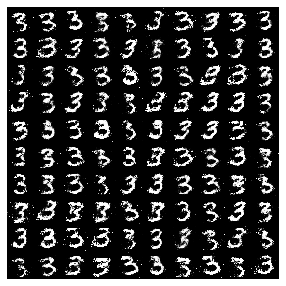

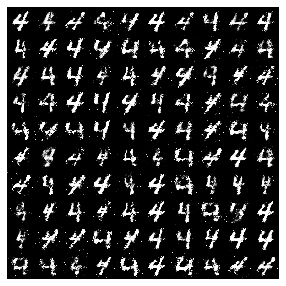

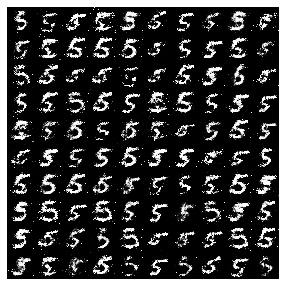

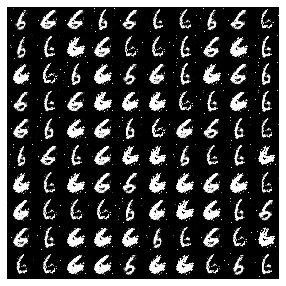

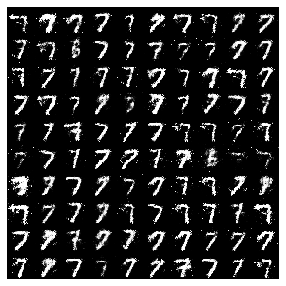

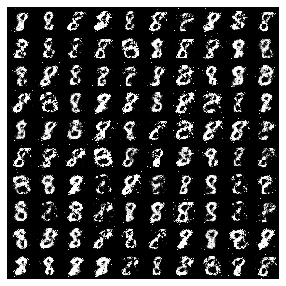

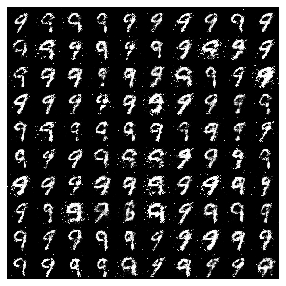

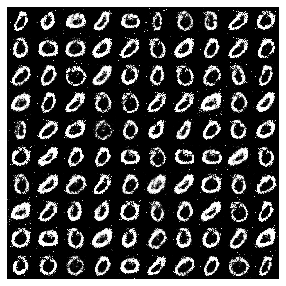

In [6]:
latent_dim = 64

# we'll use Adam optimizer
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the generator
z = Input(shape=(latent_dim,))
label = Input(shape=(1,))

generator = build_generator(z, label)

# Generator input z
generated_image = generator([z, label])

# Only train the generator for the combined model
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
real_or_fake = discriminator([generated_image, label])

# Stack the generator and discriminator in a combined model
# Trains the generator to deceive the discriminator
combined = Model([z, label], real_or_fake)
combined.compile(loss='binary_crossentropy',
                 optimizer=optimizer)

# train the GAN system
train(generator=generator,
      discriminator=discriminator,
      combined=combined,
      steps=50000,
      batch_size=100)

# display some random generated images
plot_generated_images(generator, 1)
plot_generated_images(generator, 2)
plot_generated_images(generator, 3)
plot_generated_images(generator, 4)
plot_generated_images(generator, 5)
plot_generated_images(generator, 6)
plot_generated_images(generator, 7)
plot_generated_images(generator, 8)
plot_generated_images(generator, 9)
plot_generated_images(generator, 0)